<a href="https://colab.research.google.com/github/Nadiam75/video_captioning_dataloader/blob/main/dataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [237]:
import cv2
import csv
import numpy as np
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


In [238]:
CSV_FILE = 'file_names.csv'
DISPLAY_FRAMES = True
SAVE_FRAMES = True
BATCH_SIZE = 2
HOLD = 10  # ms

In [240]:
def frame_sampling(video_path, vid_capture, number_of_samples, frame_count):
    saving_frame_numbers = [int(frame_count // number_of_samples * i) for i in range(number_of_samples)]
    all_frames = []
    saved_path_list = []

    count = -1
    while vid_capture.isOpened() and len(saving_frame_numbers) >= 1:

        count += 1
        success, frame = vid_capture.read()
        new_frame = frame[np.newaxis, :]

        if success and count == saving_frame_numbers[0]:
            all_frames.append(new_frame)
            del [saving_frame_numbers[0]]

            if DISPLAY_FRAMES and SAVE_FRAMES:
                save_path = ('sampled_frames/' + video_path.replace('.mp4', '')) + ("frame_%d.jpg" % count)
                cv2.imwrite(save_path, frame)
                all_frames.append(new_frame)
                saved_path_list.append(save_path)
                cv2.imshow('Frame', frame)
                key = cv2.waitKey(HOLD)
                if key == ord('q'):
                    break

            elif not DISPLAY_FRAMES and SAVE_FRAMES:
                save_path = ('sampled_frames/' + video_path.replace('.mp4', '')) + ("frame_%d.jpg" % count)
                all_frames.append(new_frame)
                saved_path_list.append(save_path)
                cv2.imwrite(save_path, frame)

            elif DISPLAY_FRAMES and not SAVE_FRAMES:
                all_frames.append(new_frame)
                cv2.imshow('Frame', frame)
                key = cv2.waitKey(HOLD)
                if key == ord('q'):
                    break

    vid_capture.release()
    cv2.destroyAllWindows()
    summerized_video = np.vstack(all_frames)
    return saved_path_list, summerized_video

In [241]:
def generate_dataset(csv_path, number_of_samples=10):
    captions = []
    selected_frame_paths = []
    all_images = []
    with open(csv_path, encoding='utf-8-sig') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if row[0] == 'path':
                continue
            captions.append(row[1])

            vid_capture = cv2.VideoCapture(row[0])

            if not vid_capture.isOpened():
                print("Error opening the video file")
            else:
                frame_count = vid_capture.get(7)
                print('Frame count : ', frame_count)
            saved_path_list, selected_frame_images = frame_sampling(row[0], vid_capture, number_of_samples, frame_count)
            all_images.append(selected_frame_images)

            selected_frame_paths.append(saved_path_list)

    data = {'video_frames': all_images, 'captions': captions}
    data_frame = pd.DataFrame(data)
    return data_frame


In [242]:
class MovieCaptioningDataset (Dataset):
  def __init__ (self , df ):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row =  self.df.iloc[idx]
    video_frame = row.video_frames
    caption = row.captions
    return video_frame , caption

In [243]:
generated_df = generate_dataset (CSV_FILE, number_of_samples = 10)

Frame count :  1655.0
Frame count :  382.0
Frame count :  774.0
Frame count :  1655.0
Frame count :  3182.0


In [244]:
train_df , valid_df = train_test_split ( generated_df , test_size = 0.2 , random_state = 42)

In [246]:
train_set = MovieCaptioningDataset(train_df)
valid_set = MovieCaptioningDataset(valid_df)
print(f"Size of Trainset : {len(train_set)}")
print(f"Size of Validset : {len(valid_set)}")

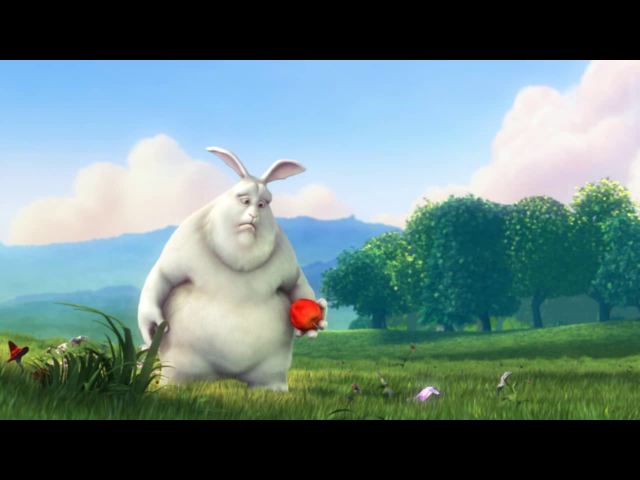

In [255]:
movie_idx = 2
frame_idx = 7
frames, _ = train_set[movie_idx]
cv2_imshow(frames[frame_idx])
cv2.waitKey(0)
cv2.destroyAllWindows()

In [256]:
trainloader = DataLoader (train_set, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(valid_set, batch_size = BATCH_SIZE)

In [257]:
print(f'total num of batches in trainloader: {len(trainloader)}')
print(f'total num of batches in validloader: {len(validloader)}')

total num of batches in trainloader: 2
total num of batches in validloader: 1


In [258]:
for videoframe, caption in trainloader:
  break
print(f'this is the shape of the frames sampled from a video in a  batch: {videoframe.shape}')
print(f'this is an example of the captions in a batch: {caption}')

this is the shape of the frames sampled from a video in a  batch: torch.Size([2, 10, 480, 640, 3])
this is an example of the captions in a batch: ('cap1', 'cap5')
